In [53]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
from read_positions import read_positions
from perspective import *
import random
%matplotlib inline
import random
from helper import *



In [2]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
df = df[(df['Camera'] == 1) | (df['Camera'] == 2)]
df.head(11)

,Camera,Date,X_center,Y_center,Width,Height
0,2,2024-01-25 17:30:00,0.706510,0.4770,0.207813,0.316
1,2,2024-01-25 17:30:00,0.897135,0.5390,0.192188,0.472
3,2,2024-01-29 16:30:00,0.829427,0.5375,0.214062,0.285
4,2,2024-01-29 16:30:00,0.660677,0.3940,0.174479,0.376
5,2,2024-01-29 02:45:00,0.432552,0.8830,0.177604,0.192
6,2,2024-01-29 02:45:00,0.646094,0.7320,0.229687,0.282
7,2,2024-01-29 02:45:00,0.311719,0.5895,0.234896,0.233
8,2,2024-02-05 18:30:00,0.785677,0.4470,0.177604,0.302
9,2,2024-02-05 18:30:00,0.130469,0.5195,0.151562,0.301
10,2,2024-02-05 18:30:00,0.212760,0.7975,0.238021,0.395


In [3]:
background = cv2.imread('back.jpeg')

In [54]:
# H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

df_proj_overlap = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Point1', 'Point2', 'Point3', 'Point4'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    map_width, map_height = CAMERA_to_MAP[data['Camera']]
    H = CAMERA_to_H[data['Camera']]
    opposing_camera = OPPOSING_CAMERA[data['Camera']]
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height)
    x_proj, y_proj, polygon= transform_row2(H, x, y, width, height)

    map_width, map_height = MAP_WIDTH12, MAP_HEIGHT12
    polygon = [(x/map_width, y/map_height) for x, y in polygon]
    # print(polygon)  
    data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    for idx, col in enumerate(['Point1', 'Point2', 'Point3', 'Point4']):
        data[col] = polygon[idx]
    if row_exists(data['Date'], df=df_proj_overlap, opposing_camera=opposing_camera, heatmap_width=map_width, heatmap_height=map_height, curr_row=data):
        continue
    if data['Camera'] == 2 and random.random() > 0.35:
        continue
    df_proj_overlap = pd.concat([df_proj_overlap, pd.DataFrame([data])], ignore_index=True)
print(f'LEN = {len(df_proj_overlap)}')
df_proj_overlap.head()

/tmp/ipykernel_1018439/2358143997.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj_overlap = pd.concat([df_proj_overlap, pd.DataFrame([data])], ignore_index=True)


LEN = 728


,Camera,Date,X_center,Y_center,Point1,Point2,Point3,Point4
0,2,2024-01-25 17:30:00,0.521538,0.857321,"(0.6550795653156031, 0.8951674241286057)","(0.5939847999644057, 1.0525972593080748)","(0.4297821544041143, 0.8313166478297094)","(0.4705045468339296, 0.7197648161774749)"
1,2,2024-02-05 18:30:00,0.635991,0.476042,"(0.7777657196900555, 0.44856785060642484)","(0.7327785313686478, 0.5658522385817307)","(0.5361862895644713, 0.4953828291459517)","(0.5666232242762486, 0.41167391263521635)"
2,2,2024-02-05 18:30:00,0.471033,0.475528,"(0.5783733474874051, 0.43769222873074193)","(0.5289066706862405, 0.573036140495247)","(0.3947834121846707, 0.5024049665544417)","(0.4290589662355797, 0.40480881804352875)"
3,2,2024-01-22 23:30:00,0.401408,0.859332,"(0.5088781909407857, 0.9255011498511254)","(0.4619969162985543, 1.0503207120028408)","(0.3294835669972072, 0.8150473107824793)","(0.3600590786087179, 0.7289889142229841)"
4,1,2024-01-24 12:15:00,0.500409,0.466602,"(0.3717195386084441, 0.5189005178171437)","(0.37725469999224226, 0.31053972577715255)","(0.5777157221999124, 0.43518575921758906)","(0.5789745366461924, 0.5661603487454928)"


In [43]:
df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Point1', 'Point2', 'Point3', 'Point4'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    data['Date'] = row['Date']
    map_width, map_height = CAMERA_to_MAP[data['Camera']]
    H = CAMERA_to_H[data['Camera']]
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height)
    x_proj, y_proj, polygon= transform_row2(H, x, y, width, height)

    map_width, map_height = MAP_WIDTH12, MAP_HEIGHT12
    polygon = [(x/map_width, y/map_height) for x, y in polygon]
    # print(polygon)  
    data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    for idx, col in enumerate(['Point1', 'Point2', 'Point3', 'Point4']):
        data[col] = polygon[idx]
    
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
df_proj.head()
print(f'LEN = {len(df_proj)}')

/tmp/ipykernel_1018439/3096033509.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


LEN = 1515


In [40]:
def get_heatmap_new(df, camera):
    df = df[df['Camera'].isin(camera)]
    # print(df['Camera'])

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 856, 572

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap_polygon(cx, cy, points, heatmap):
        vertices = np.array(points, dtype=np.int32)
    
        # Calculate the bounding box of the polygon to limit the area for the point-in-polygon test
        p_x, p_y, width, height = cv2.boundingRect(vertices)
        left = max(0, p_x)
        right = min(heatmap_width-1, p_x + width)
        top = max(0, p_y)
        bottom = min(heatmap_height-1, p_y + height)
    
        # Calculate sigma values based on the bounding box
        # width = bounding_box[2]
        # height = bounding_box[3]
        sigma_x = width / 4
        sigma_y = height / 4
        # Iterate over each point in the bounding box
        for y in range(top, bottom):
            for x in range(left, right):
                # Check if the point is inside the polygon
                if cv2.pointPolygonTest(vertices, (x, y), False) >= 0:
                    # Apply Gaussian intensity if the point is inside
                    dx = cx - x
                    dy = cy - y
                    value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                    heatmap[y, x] += value
                    
    for index, row in df.iterrows():
        cx, cy = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height
        cols = ['Point1', 'Point2', 'Point3', 'Point4']
        polygon = [(float(row[col][0])*heatmap_width, float(row[col][1]) *heatmap_height) for col in cols]
    
        apply_bounded_gaussian_heatmap_polygon(cx, cy, polygon, heatmap_img)


    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    #heatmap_img[zero_mask] = 0
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color


0      2
1      2
2      2
3      2
4      1
      ..
723    1
724    2
725    2
726    2
727    2
Name: Camera, Length: 728, dtype: object


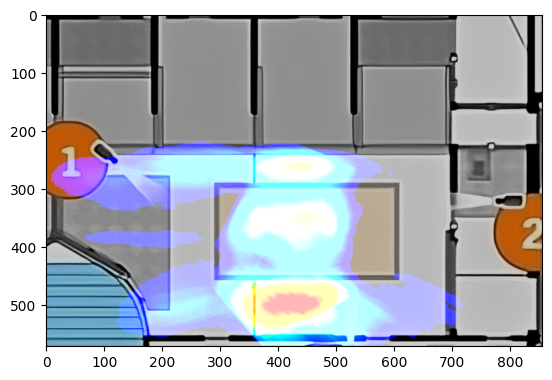

In [55]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_proj_overlap, [1, 2])
overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


12      1
13      1
22      1
23      1
54      1
       ..
1480    1
1481    1
1492    1
1493    1
1494    1
Name: Camera, Length: 393, dtype: object


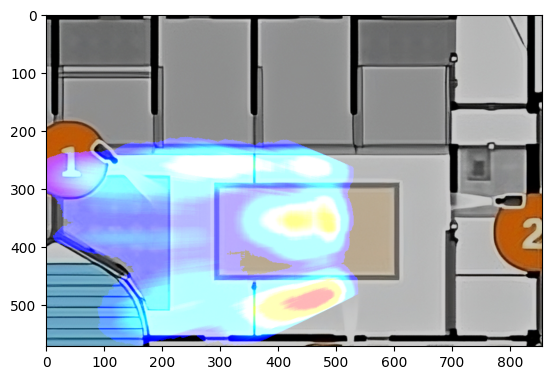

In [44]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_proj, [1])
overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


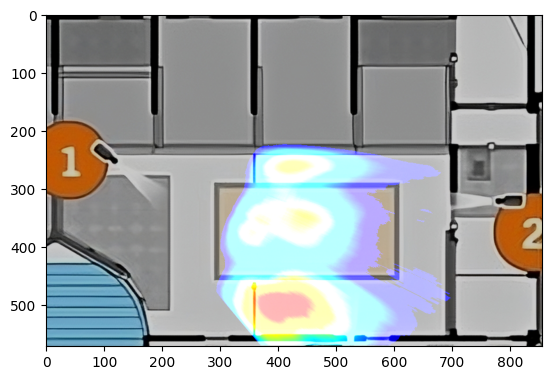

In [37]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_proj, [2])
overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


In [51]:
len(df_proj_overlap[df_proj_overlap['Camera']==1])


303